# Multi-Head Attention の実装と理解

このノートブックでは、Multi-Head Attention機構を実装し、その動作を理解します。

## 1. Multi-Head Attentionとは

Multi-Head Attentionは、Self-Attentionを複数並列に実行する仕組みです。

### 主な特徴:

1. **複数のAttention Head**: 異なる表現部分空間から情報を捉える
2. **並列処理**: 各headは独立して計算される
3. **結合と変換**: 全headの出力を結合し、線形変換する

### 数式:

$$
\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, ..., \text{head}_h)W^O
$$

各headは:

$$
\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)
$$

### パラメータ:

- $h$: head数(通常8個)
- $d_{\text{model}}$: モデルの次元(例: 512)
- $d_k = d_v = d_{\text{model}} / h$: 各headの次元(例: 64)

## 2. 必要なライブラリのインポート

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
import numpy as np

# 日本語フォント設定
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'Hiragino Sans']
plt.rcParams['axes.unicode_minus'] = False

print(f"PyTorch version: {torch.__version__}")

ModuleNotFoundError: No module named 'torch'

## 3. Multi-Head Attentionの実装

In [ ]:
class MultiHeadAttention(nn.Module):
    """
    Multi-Head Attention機構の実装
    
    Args:
        d_model: モデルの次元数
        num_heads: Attention headの数
    """
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        
        # d_modelがnum_headsで割り切れることを確認
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads  # 各headの次元
        
        # Q, K, V用の線形変換層（全headをまとめて処理）
        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_k = nn.Linear(d_model, d_model, bias=False)
        self.W_v = nn.Linear(d_model, d_model, bias=False)
        
        # 出力用の線形変換層
        self.W_o = nn.Linear(d_model, d_model, bias=False)
        
    def split_heads(self, x, batch_size):
        """
        入力を複数のheadに分割
        
        Args:
            x: shape [batch_size, seq_len, d_model]
        Returns:
            shape [batch_size, num_heads, seq_len, d_k]
        """
        x = x.view(batch_size, -1, self.num_heads, self.d_k)
        return x.transpose(1, 2)
    
    def forward(self, query, key, value, mask=None):
        """
        Multi-Head Attentionの順伝播
        
        Args:
            query: shape [batch_size, seq_len, d_model]
            key: shape [batch_size, seq_len, d_model]
            value: shape [batch_size, seq_len, d_model]
            mask: Optional mask
        Returns:
            output: shape [batch_size, seq_len, d_model]
            attention_weights: shape [batch_size, num_heads, seq_len, seq_len]
        """
        batch_size = query.size(0)
        
        # 1. 線形変換: [batch, seq_len, d_model]
        Q = self.W_q(query)
        K = self.W_k(key)
        V = self.W_v(value)
        
        # 2. 複数headに分割: [batch, num_heads, seq_len, d_k]
        Q = self.split_heads(Q, batch_size)
        K = self.split_heads(K, batch_size)
        V = self.split_heads(V, batch_size)
        
        # 3. Scaled Dot-Product Attention
        # scores: [batch, num_heads, seq_len, seq_len]
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        # マスクの適用（オプション）
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        # Attention重み: [batch, num_heads, seq_len, seq_len]
        attention_weights = F.softmax(scores, dim=-1)
        
        # Attentionの適用: [batch, num_heads, seq_len, d_k]
        attention_output = torch.matmul(attention_weights, V)
        
        # 4. 全headを結合: [batch, seq_len, d_model]
        attention_output = attention_output.transpose(1, 2).contiguous()
        attention_output = attention_output.view(batch_size, -1, self.d_model)
        
        # 5. 出力線形変換
        output = self.W_o(attention_output)
        
        return output, attention_weights

## 4. 動作確認

Multi-Head Attentionの基本的な動作を確認します。

In [4]:
# ハイパーパラメータ
d_model = 512
num_heads = 8
batch_size = 2
seq_len = 10

# Multi-Head Attentionの作成
mha = MultiHeadAttention(d_model, num_heads)

# ランダムな入力を作成
x = torch.randn(batch_size, seq_len, d_model)

# 順伝播
output, attention_weights = mha(x, x, x)

print("入力の形状:", x.shape)
print("出力の形状:", output.shape)
print("Attention重みの形状:", attention_weights.shape)
print(f"\nnum_heads: {num_heads}")
print(f"d_k (各headの次元): {mha.d_k}")
print(f"d_model: {d_model}")

入力の形状: torch.Size([2, 10, 512])
出力の形状: torch.Size([2, 10, 512])
Attention重みの形状: torch.Size([2, 8, 10, 10])

num_heads: 8
d_k (各headの次元): 64
d_model: 512


## 5. パラメータ数の確認

Multi-Head Attentionの学習パラメータを確認します。

In [5]:
print("Multi-Head Attentionのパラメータ:")
print("=" * 60)

total_params = 0
for name, param in mha.named_parameters():
    num_params = param.numel()
    total_params += num_params
    print(f"{name:20s}: shape {str(list(param.shape)):20s} = {num_params:,} params")

print("=" * 60)
print(f"総パラメータ数: {total_params:,}")
print(f"\n計算式: 4 × (d_model × d_model) = 4 × ({d_model} × {d_model}) = {4 * d_model * d_model:,}")

Multi-Head Attentionのパラメータ:
W_q.weight          : shape [512, 512]           = 262,144 params
W_k.weight          : shape [512, 512]           = 262,144 params
W_v.weight          : shape [512, 512]           = 262,144 params
W_o.weight          : shape [512, 512]           = 262,144 params
総パラメータ数: 1,048,576

計算式: 4 × (d_model × d_model) = 4 × (512 × 512) = 1,048,576


## 6. Attention重みの可視化

各headがどのように異なる情報を捉えているかを可視化します。

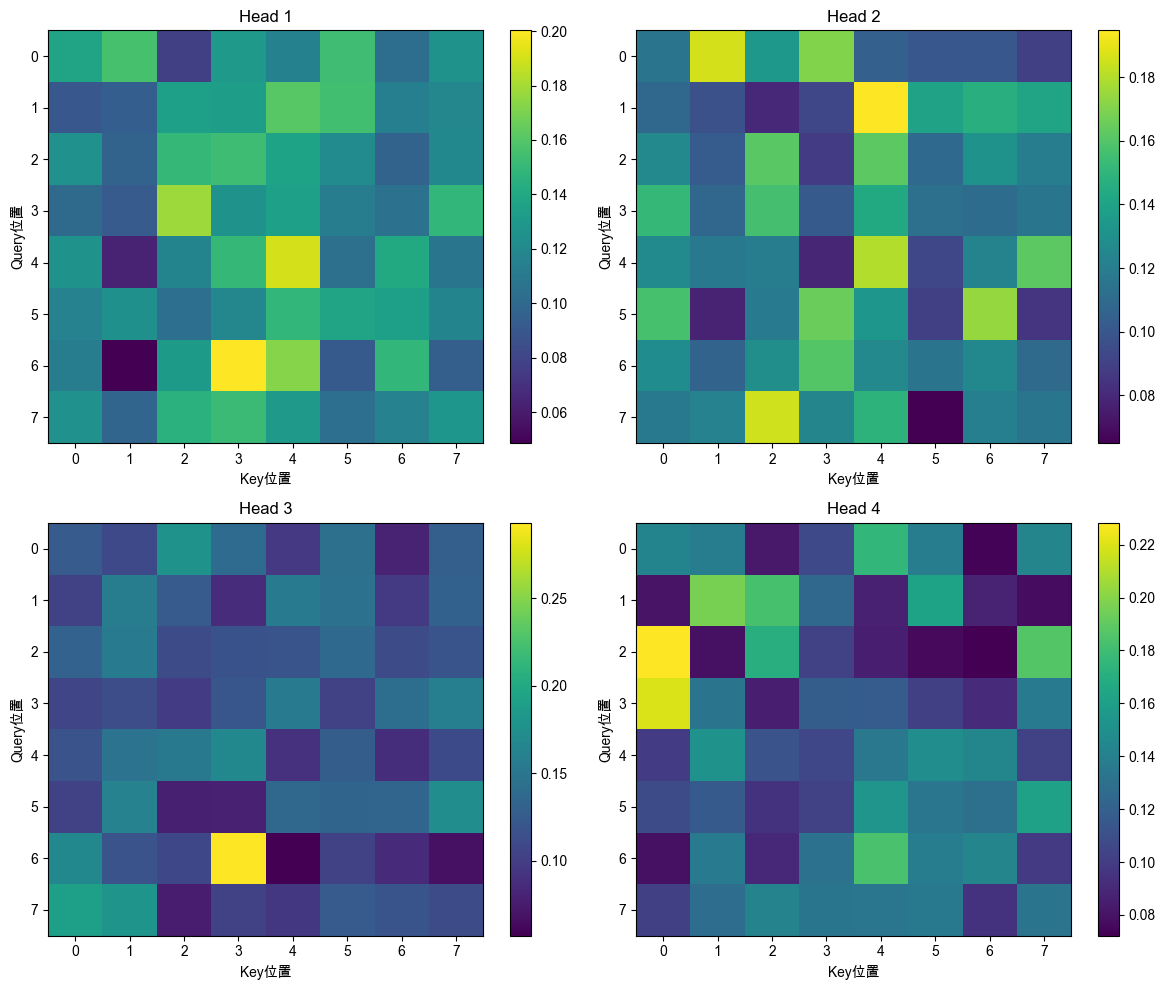

各headが異なるパターンの注意を学習していることがわかります


In [6]:
# 簡単な例で可視化
d_model_small = 64
num_heads_small = 4
seq_len_small = 8

mha_small = MultiHeadAttention(d_model_small, num_heads_small)
x_small = torch.randn(1, seq_len_small, d_model_small)

output_small, attention_weights_small = mha_small(x_small, x_small, x_small)

# 各headのAttention重みを可視化
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i in range(num_heads_small):
    # [seq_len, seq_len]
    attn = attention_weights_small[0, i].detach().numpy()
    
    im = axes[i].imshow(attn, cmap='viridis', aspect='auto')
    axes[i].set_title(f'Head {i+1}')
    axes[i].set_xlabel('Key位置')
    axes[i].set_ylabel('Query位置')
    plt.colorbar(im, ax=axes[i])

plt.tight_layout()
plt.savefig('multi_head_attention_weights.png', dpi=150, bbox_inches='tight')
plt.show()

print("各headが異なるパターンの注意を学習していることがわかります")

## 7. Multi-HeadとSingle-Headの比較

In [7]:
# 同じd_modelでhead数を変えて比較
d_model_comp = 64

# Single-Head (num_heads=1)
mha_single = MultiHeadAttention(d_model_comp, num_heads=1)
single_params = sum(p.numel() for p in mha_single.parameters())

# Multi-Head (num_heads=8)
mha_multi = MultiHeadAttention(d_model_comp, num_heads=8)
multi_params = sum(p.numel() for p in mha_multi.parameters())

print("Single-Head vs Multi-Head の比較:")
print("=" * 50)
print(f"Single-Head (num_heads=1):")
print(f"  - d_k = {mha_single.d_k}")
print(f"  - パラメータ数: {single_params:,}")
print()
print(f"Multi-Head (num_heads=8):")
print(f"  - d_k = {mha_multi.d_k}")
print(f"  - パラメータ数: {multi_params:,}")
print()
print(f"パラメータ数は同じ: {single_params == multi_params}")
print("\n💡 重要: Multi-Headでもパラメータ数は増えません!")
print("   各headのd_kが小さくなるため、総計算量は同じです。")
print("   しかし、異なる表現部分空間から情報を学習できます。")

Single-Head vs Multi-Head の比較:
Single-Head (num_heads=1):
  - d_k = 64
  - パラメータ数: 16,384

Multi-Head (num_heads=8):
  - d_k = 8
  - パラメータ数: 16,384

パラメータ数は同じ: True

💡 重要: Multi-Headでもパラメータ数は増えません!
   各headのd_kが小さくなるため、総計算量は同じです。
   しかし、異なる表現部分空間から情報を学習できます。


## 8. まとめ

### Multi-Head Attentionの利点:

1. **複数の表現部分空間**: 異なる種類の情報（位置、意味、文法など）を並列に学習
2. **パラメータ効率**: head数を増やしてもパラメータ数は変わらない
3. **表現力の向上**: 単一のAttentionよりも豊かな表現を学習

### 実装のポイント:

1. `d_model % num_heads == 0` が必要
2. 各headの次元: `d_k = d_model / num_heads`
3. 全headをまとめて処理することで効率化
4. 最後に出力を結合して線形変換

### 次のステップ:

- Position Encoding: 系列の位置情報を埋め込む
- Feed Forward Network: Attention後の非線形変換
- Encoder/Decoderブロックの構築